In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
import util, defs, models

In [6]:
bg_consts, sig_consts, bg_jets, sig_jets = util.load_data()
    
print(bg_consts.shape)
print(sig_consts.shape)

(297233, 96, 3)
(392759, 96, 3)


In [7]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

print("Training set:  ", X_train.shape)
print("Validation set:", X_val.shape)

Training set:   (505298, 96, 3)
Validation set: (89168, 96, 3)


In [282]:
K.clear_session()


benchmark_LL_nonaug, benchmark_LL_aug, shuffler, calc = models.mk_benchmark_LL(defs.N_CONST,
                                                        **defs.BENCHMARK_LL_ARGS)


benchmark_LL = benchmark_LL_aug

HL_val = calc.predict(X_val)

benchmark_LL.h = util.HistoryCB(val_data=(X_val, y_val))

benchmark_LL_nonaug.summary()

Model: "classifier_LL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 3)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 96, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)            

In [345]:
epochs = 16

batch_size = 512 #128

learning_rate = 3e-4


K.set_value(benchmark_LL.optimizer.lr, learning_rate)


stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=2,
                                   mode='min', restore_best_weights=True)

try:
    benchmark_LL.fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     callbacks=[benchmark_LL.h],
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 505298 samples, validate on 89168 samples
Epoch 1/16
505298/505298 [==============================] - 7s 15us/step - loss: 0.5136 - val_loss: 0.5145
Epoch 2/16
505298/505298 [==============================] - 7s 15us/step - loss: 0.5136 - val_loss: 0.5090
Epoch 3/16
505298/505298 [==============================] - 8s 15us/step - loss: 0.5139 - val_loss: 0.5095
Epoch 4/16
505298/505298 [==============================] - 7s 15us/step - loss: 0.5140 - val_loss: 0.5090
Epoch 5/16
505298/505298 [==============================] - 7s 14us/step - loss: 0.5136 - val_loss: 0.5158
Epoch 6/16
505298/505298 [==============================] - 8s 15us/step - loss: 0.5137 - val_loss: 0.5079
Epoch 7/16
505298/505298 [==============================] - 8s 16us/step - loss: 0.5134 - val_loss: 0.5277
Epoch 8/16
505298/505298 [==============================] - 8s 15us/step - loss: 0.5136 - val_loss: 0.5105
Epoch 9/16
505298/505298 [==============================] - 8s 15us/step - loss: 0.5131 - val

Validation AUC: 0.8420023033012336
          best: 0.8437683653936277
         ibest: 399/400


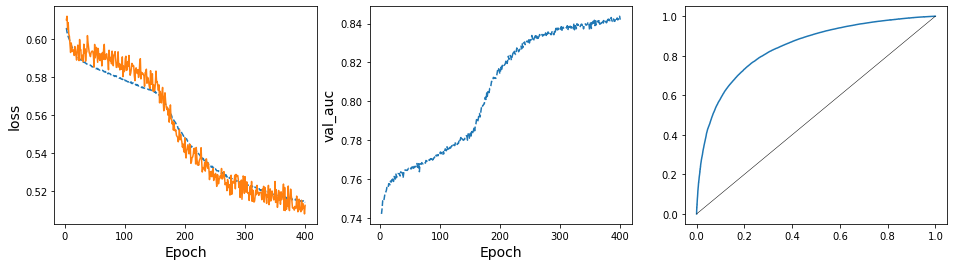

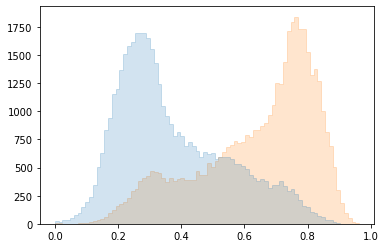

In [344]:
benchmark_LL.h.plot(['loss', 'val_auc', 'roc'], nskip=2,
                    figsize=plt.figaspect(0.25))
print("Validation AUC:", benchmark_LL.h.history['val_auc'][-1])
print("          best:", np.max(benchmark_LL.h.history['val_auc']))
print("         ibest: %d/%d"%(np.argmax(benchmark_LL.h.history['val_auc'])+1, benchmark_LL.h.epoch_total))

plt.figure()
preds_val = benchmark_LL.predict(X_val, batch_size=512).squeeze()
plt.hist([preds_val[y_val==0], preds_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2);

In [ ]:
# best: 0.846 (5 layer + dropout)

/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


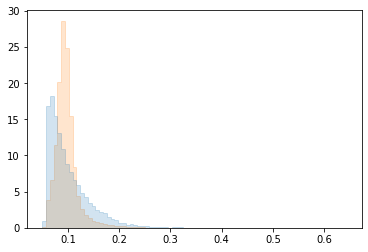

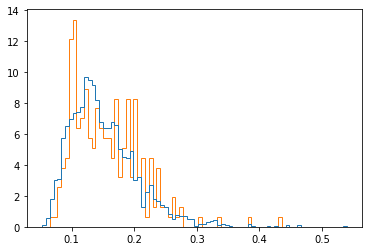

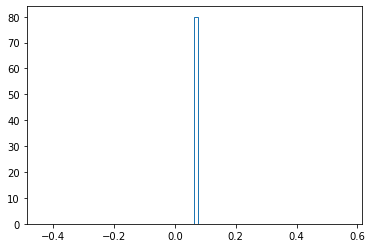

In [162]:
plt.hist([HL_val[:,3][y_val==0], HL_val[:,3][y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val<0.2)], HL_val[:,3][(y_val==1)*(preds_val<0.2)]], histtype='step', bins=80, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val>0.8)], HL_val[:,3][(y_val==1)*(preds_val>0.8)]], histtype='step', bins=80, density=True);

0.026155412197113037
0.42326484620571136
0.5250938057899475
0.6164753079414368
0.6557076305150985
0.7037486743927002


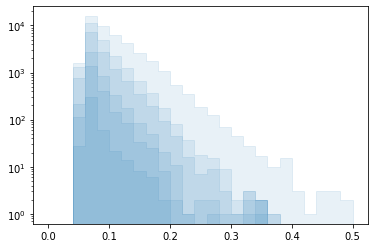

In [163]:
for q in np.quantile(preds_val[y_val==0], (0,0.5,0.7,0.9,0.95,0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==0)*(preds_val>q)], histtype='step', bins=25, range=(0,0.5), color='C0', alpha=0.1, fill=True)
plt.yscale('log');

0.7958492636680603
0.5699610710144043
0.5073096513748169
0.375879830121994
0.31820842027664187
0.22224053710699085


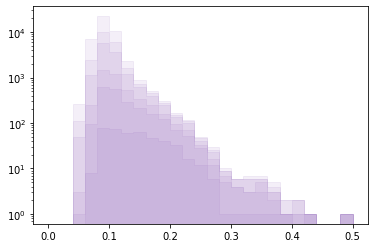

In [164]:
for q in np.quantile(preds_val[y_val==1], (1-0.0,1-0.5,1-0.7,1-0.9,1-0.95,1-0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==1)*(preds_val<q)], histtype='step', bins=25, range=(0,0.5), color='C4', alpha=0.1, fill=True)
plt.yscale('log');

In [44]:
save_model = False

if save_model:
    if shuffle_particles:
        file_name = 'model_benchmark_LL_shuff.h5'
    else:
        file_name = 'model_benchmark_LL.h5'
    
    benchmark_LL_nonaug.save(file_name)
    print("Saved to", file_name)